### Initialization Cell

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import numpy as np, pandas as pd

def chi2(y,yfit):
    res = 0
    for i in range(len(yfit)):
        res = res + (y[i]-yfit[i])**2/(0.9724)**2 #The denominator should be the unbias Sipm voltage in mV
    return (res / len(yfit))

def waveform(x, C, start, m, end, A, d):
    condlist = [x < start, (x >= start) & (x < end), x >= end]
    funclist = [lambda x: C, lambda x: m*x+(C - m*start), lambda x: (A*(np.exp(d*x)-np.exp(d*end)) + m*(end-start) + C)]
    return np.piecewise(x, condlist, funclist)

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def get_chi2(fitparams,times,voltages):
    startindex=10
    for i in range(len(times)): 
        if times[i] < popt[1]: startindex = i
        else: break
    chisq = chi2(voltages[0:startindex],waveform(time[0:startindex], *fitparams))
    return chisq

def get_amplitude_raw(voltages):
    v_max=max(voltages)
    v_min=min(voltages[0:findindex(voltages,v_max)+1])
    return v_max-v_min

def get_amplitude_base(fitparams,voltages):
    v_min = fitparams[0]
    v_max=max(voltages)
    return v_max-v_min

def get_amplitude_fit(fitparams):
    linearrise = fitparams[2]*(fitparams[3]-fitparams[1])
    return linearrise

def get_time_raw(times,voltages):
    pretimes = times[0:findindex(voltages,max(voltages))+1]
    prevoltages = voltages[0:findindex(voltages,max(voltages))+1]
    halfamp = 0.5*(max(voltages)+min(prevoltages))
    halfvolt = []
    for voltage in prevoltages:
        halfvolt.append(abs(voltage-halfamp))
    
    halftime = pretimes[findindex(halfvolt,min(halfvolt))]
    return halftime

def get_time_fit(fitparams):
    pulse_time = fitparams[1]/2+fitparams[3]/2
    return pulse_time

def get_time_fit_CDF(fitparams):
    pulse_time = fitparams[1]/2+fitparams[3]/2
    return pulse_time

### User Defined Inputs

In [4]:
inputfiles = ["../LongbarTiming/3_old.txt"]  #list input files
outputfile = './rhtrigger15mVor.txt'          #set output file location
filenumber = len(inputfiles)
channelnum = [1,2,3,4]             #list DRS4 board channels to record, ranges 1 to 4
eventview = False

#choose which stats to analyze for each waveform
do_chi2 = 1
do_amplitude_raw = 1
do_amplitude_fit = 1
do_amplitude_base = 1
do_time_raw = 1
do_time_fit = 1
do_time_CDF = 0

#p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
p0=[(0,85,1,95,200,-0.01),       #ch1 initial parameters
    (0,85,1,95,200,-0.01),       #ch2 initial parameters
    (0,100,1,110,200,-0.01),        #ch3 initial parameters
    (0,100,1,110,200,-0.01)]        #ch4 initial parameters
#chi2cut = 2
#Vcut = 20 #cut just above noise level, in (mV) 

channelnames=[]
for ch in channelnum:
    channelnames.append(f'ch{ch}')
#Add each stat to the dataframe
stats=[]
if do_chi2: stats.append("chisq")
if do_amplitude_raw: stats.append("P2P_raw")
if do_amplitude_base: stats.append("P2P_base")
if do_amplitude_fit: stats.append("P2P_fit")
if do_time_raw: stats.append("time_raw")
if do_time_fit: stats.append("time_fit")
if do_time_CDF: stats.append("time_CDF")

In [5]:
stats

['chisq', 'P2P_raw', 'P2P_base', 'P2P_fit', 'time_raw', 'time_fit']

### Convert to P2P!

In [5]:
din = {a+"_"+b:[] for a in channelnames for b in stats}

with open(outputfile, 'w') as w:
    #w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel(s) {channelnum}, stats {stats}")
        with open(inputfiles[i]) as f:
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events 
            
            time = np.array([])
            voltage = [np.array([])]*4
            lines = current_file[j].split('\n')
            
            if eventview: #show the waveform fit line
                print(f"Event Number {j}")
                fig,ax = plt.subplots(1,4,figsize=(10,3))
                ax[0].set_title("Ch. 1")
                ax[1].set_title("Ch. 2")
                ax[2].set_title("Ch. 3")
                ax[3].set_title("Ch. 4")
            
            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                time = np.append(time, float(values[2]))
                for channel in channelnum:
                    #if float(values[channel+2]) < Vcut: continue            #cut the false peaks from the DRS4 -- mismatches length of time list
                    voltage[channel-1] = np.append(voltage[channel-1], float(values[channel+2]))
            w.write('\n')
            for channel in channelnum:
                print(f"Event: {j}, Channel: {channel}",end="\r") #,end="\r"
                #only attempt a fit if it looks like there's not nothing
                totalrms = sum((voltage[channel-1]-np.mean(voltage[channel-1]))**2)/len(voltage[channel-1])
                if totalrms < 5:
                    popt = (np.mean(voltage[channel-1]),0,0,0,0,1)
                else:
                    popt, pcov = curve_fit(waveform, time, voltage[channel-1],p0=p0[channel-1],
                                           maxfev = 100000)#,bounds=([-10,60,0,60,0,-1],[10,140,100,140,3000,0])
                #calculate chi^2
                if do_chi2:
                    chisq = get_chi2(popt,time,voltage[channel-1])
                    din[f'ch{channel}_chisq'].append(chisq)
                    w.write(f"{chisq:.2f}\t")
                
                #calculate amplitude
                if do_amplitude_raw: 
                    amplitude = get_amplitude_raw(voltage[channel-1])
                    din[f'ch{channel}_P2P_raw'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                
                if do_amplitude_base: 
                    amplitude = get_amplitude_base(popt,voltage[channel-1])
                    din[f'ch{channel}_P2P_base'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                    
                if do_amplitude_fit: 
                    amplitude = get_amplitude_fit(popt)
                    din[f'ch{channel}_P2P_fit'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                
                #calculate time
                if do_time_raw: 
                    pulse_time = get_time_raw(time,voltage[channel-1])
                    din[f'ch{channel}_time_raw'].append(pulse_time)
                    w.write(f"{pulse_time:.1f}\t")
                    
                if do_time_fit: 
                    pulse_time = get_time_fit(popt)
                    din[f'ch{channel}_time_fit'].append(pulse_time)
                    w.write(f"{pulse_time:.1f}\t")
                   
                if eventview: #show the waveform fit line
                    print(f"Channel {channel} params: {popt[0]:.2f}, {popt[1]:.1f}, {popt[2]:.2f}, {popt[3]:.1f}, {popt[4]:.2f}, {popt[5]:.3f}")
                    xs = []
                    ys = []
                    for i in range(500):
                        xs.append(i)
                        ys.append(waveform(i,*popt))
                    ax[channel-1].plot(time,voltage[channel-1],label="raw")
                    ax[channel-1].plot(xs,ys,label="fit")
                    ax[channel-1].set_xlim(50,150)
                    #ax[channel-1].set_ylim(-25,25)
                    #draw the P2P and time 
                    if do_time_raw: ax[channel-1].vlines(get_time_raw(time,voltage[channel-1]),ymin=-50,ymax=100, color='r',label="t_raw")
                    if do_time_fit: ax[channel-1].vlines(get_time_fit(popt),ymin=-50,ymax=100, color='g',label="t_fit")
                    if do_amplitude_raw: ax[channel-1].hlines(get_amplitude_raw(voltage[channel-1]),xmin=0,xmax=200, color='r',label="A_raw")
                    if do_amplitude_fit: ax[channel-1].hlines(get_amplitude_fit(popt),xmin=0,xmax=200, color='g',label="A_fit")
                    if do_amplitude_base: ax[channel-1].hlines(get_amplitude_base(popt,voltage[channel-1]),xmin=0,xmax=200, color='b',label="A_base")
            
            if eventview:
                plt.legend()        
                plt.show()
                
print(f'Done!\nTotal events analyzed: {len(din["ch2_chisq"])}')
dfin = pd.DataFrame(din)

/home/arratialab2/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done!: 10000, Channel: 4
Total events analyzed: 10000


In [46]:
voltage[channel-1]**2

array([25.  , 25.  , 27.04, ..., 16.  , 10.24, 10.24])

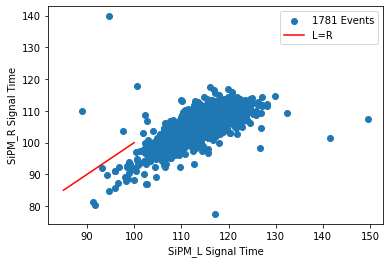

In [6]:
plt.scatter(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
plt.plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

### How to read the output file into DataFrame:

In [7]:
with open(outputfile) as f:  
    stats = []
    nchannelnames=[]
    nevents = (f.read().split('\n'))
    nchannelnums = nevents[0].split('[')[1].split(']')[0].split(', ')
    for ch in nchannelnums:
        nchannelnames.append(f'ch{ch}')
    for i in range(len(nevents[0].split('[')[2].split(']')[0].split("'"))//2):
        stats.append(nevents[0].split('[')[2].split(']')[0].split("'")[2*i+1])

    dout = {a+"_"+b:[] for a in nchannelnames for b in stats}
    for event in nevents[:]:
        #print(f'Event: {event}')
        nvalues = event.split()
        if len(nvalues) != len(stats)*len(nchannelnames): continue
        for i in range(len(nchannelnames)):
            for j in range(len(stats)):
                dout[f'{nchannelnames[i]}_{stats[j]}'].append(float(nvalues[len(stats)*i+j]))
    #print(dout)
dfout = pd.DataFrame(dout)

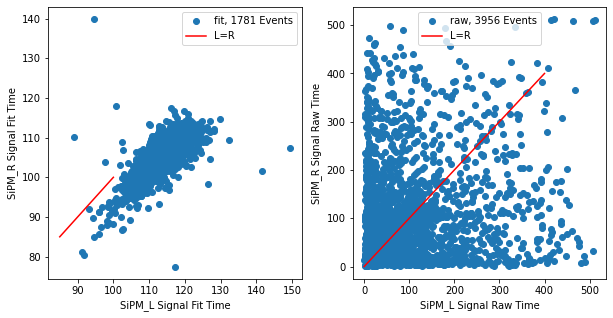

In [8]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"fit, {len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
ax[1].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")
ax[0].plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
ax[0].set_xlabel("SiPM_L Signal Fit Time")
ax[0].set_ylabel("SiPM_R Signal Fit Time")
ax[1].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[1].set_xlabel("SiPM_L Signal Raw Time")
ax[1].set_ylabel("SiPM_R Signal Raw Time")
ax[0].legend()
ax[1].legend()
plt.show()

Actual Average: -8.37, Actual st.dev.: 3.77
Fit Average:    -8.15, Fit st.dev.:    2.71


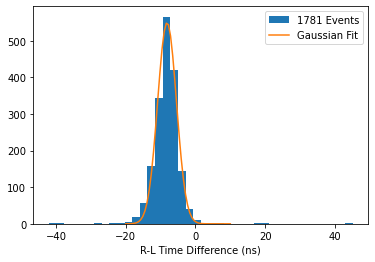

In [10]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit-dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,40, label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-20,10,50),gaus(np.linspace(-20,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.legend()
plt.show()

Actual Average: -2.13, Actual st.dev.: 88.21
Fit Average:    1.42, Fit st.dev.:    2.31


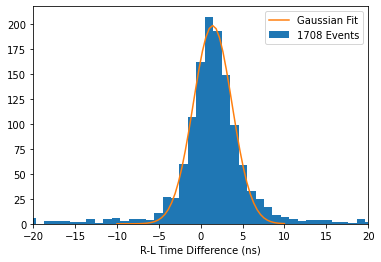

In [76]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw-dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,900, label=f"{len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count,maxfev=10000000)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.xlim(-20,20)
plt.legend()
plt.show()